## Setup 

[paper](http://idl.cs.washington.edu/papers/reverse-engineering-vis/) | [pretrained models](https://osf.io/wubdr/) | [darknet](https://github.com/visual-ds/darknet) 

The next cell will install the dependencies and, in general, prepare the environment; it will need (for the data and the pretrained models) approximately 2.5 GB of space. 

In [1]:
# install dependencies 
!conda env create -f env.yml 

# install darknet 
!git clone https://github.com/visual-ds/darknet 
!cd darknet && make 

import os 

CWD = os.path.abspath(os.getcwd()) 

with open("config.json", "w") as file: 
    config = """{{ 
    "darknet_lib_path": "{path}/./darknet" 
}}\n""".format(path = CWD + "/darknet") 
    file.write(config) 

#pretrained models 
print("Downloading models from https://osf.io/ckj5z/download")  
!wget https://osf.io/ckj5z/download -O models.zip 
!unzip models.zip 

# data 
print("Downloading data from https://osf.io/uwtsv/") 
!wget https://osf.io/uwtsv/download -O data.zip 
!unzip data.zip 


## Pipelines 

Currently, we have two methods for text localization (`craft` and `default`, that is described in the paper) and two methods for text recognition (`attn` and `tesseract`, which is the default). The general guidelines, then, of how to use it are described in the next cells; ideally, they should compute the specficiations for the chart. 

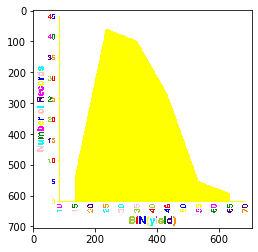

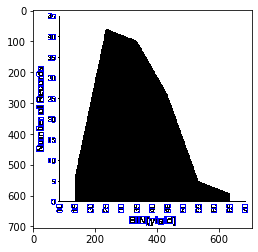

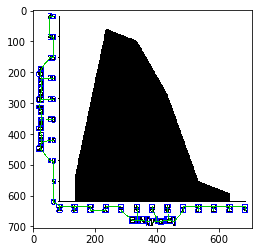

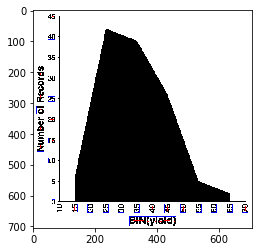

Model input parameters {'image_folder': '__temp_ocr__', 'saved_model': '../models/attn/TPS-ResNet-BiLSTM-Attn-case-sensitive.pth', 'Transformation': 'TPS', 'FeatureExtraction': 'ResNet', 'SequenceModeling': 'BiLSTM', 'Prediction': 'Attn', 'workers': 4, 'batch_size': 192, 'batch_max_length': 25, 'imgH': 32, 'imgW': 100, 'character': '0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 'num_fiducial': 20, 'input_channel': 1, 'output_channel': 512, 'hidden_size': 256, 'rgb': False, 'PAD': False, 'sensitive': True, 'num_class': 96} {'workers': 4, 'batch_size': 192, 'batch_max_length': 25, 'imgH': 32, 'imgW': 100, 'character': '0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 'num_fiducial': 20, 'input_channel': 1, 'output_channel': 512, 'hidden_size': 256, 'rgb': False, 'PAD': False, 'sensitive': True}
loading pretrained model from ../models/attn/TPS-ResNet-BiLSTM-Attn-case-sensitive.pth
confid

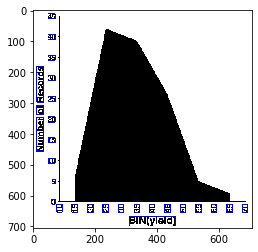

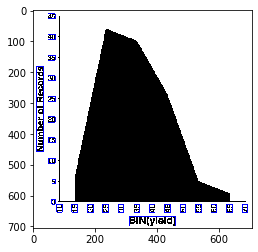

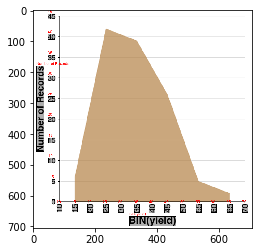

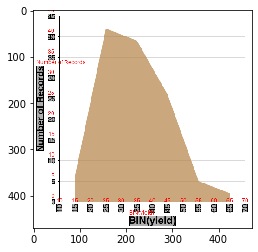

../models/mark_classifier/charts5cats/deploy.prototxt
../models/mark_classifier/charts5cats/snapshots/model_iter_50000.caffemodel
../models/mark_classifier/charts5cats/ilsvrc_2012_mean.npy


{'width': 472,
 'height': 470,
 'title': '',
 'mark': 'area',
 'encoding': {'x': {'field': '',
   'type': 'quantitative',
   'axis': {'title': 'BIN(yield)'},
   'scale': {'type': 'linear',
    'labels': ['10',
     '15',
     '20',
     '25',
     '30',
     '35',
     '40',
     '45',
     '50',
     '55',
     '60',
     '65',
     '70'],
    'values': [10.0,
     15.0,
     20.0,
     25.0,
     30.0,
     35.0,
     40.0,
     45.0,
     50.0,
     55.0,
     60.0,
     65.0,
     70.0],
    'domain': [10.0, 70.0],
    'range': [57, 457]}},
  'y': {'field': '',
   'type': 'quantitative',
   'axis': {'title': 'Number of Records'},
   'scale': {'type': 'linear',
    'labels': ['0', '5', '10', '15', '20', '25', '30', '35', '40', '45'],
    'values': [0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0],
    'domain': [0.0, 45.0],
    'range': [413, 13]}}}}

In [1]:
from IPython.display import JSON
from rev.spec.generator import SpecGenerator
import json

from rev.chart import Chart
from rev.text.localizer import TextLocalizer
from rev.text import TextClassifier

attn_parameters = { 
    # "image_folder": "imgboxes", 
    "saved_model": "../models/attn/TPS-ResNet-BiLSTM-Attn-case-sensitive.pth", 
} 

text_classifier = {
    "default": "../models/text_role_classifier/text_type_classifier.pkl" 
} 

# Load a chart 
quartz = "../data/quartz/4JevQPPu.png" # from OSF 
quartzII = "../data/quartz/4J0AakdDl.png" # from OSF 
chartp = "../examples/chart.png" 
area = "../examples/image.png" 

chart = Chart(area) 

# Text localization and recognition:
localizer = TextLocalizer(ocr = "attn", 
                          attn_params = attn_parameters)    

# set textbox information
text_boxes = localizer.localize([chart], debug = True)
chart.text_boxes = text_boxes[0]

# print(chart.text_boxes) 
# Getting the roles for each textbox
text_clf = TextClassifier(model_checkpoint = text_classifier["default"]) 

text_type_preds = text_clf.classify([chart])

# Set the role for each textbox on the chart
for (text_box, role) in zip(chart.text_boxes, text_type_preds[0]):
    text_box.type = role

# Generate specification and chart mark 
spec_gen = SpecGenerator()
spec = spec_gen.generate([chart]) 

json.loads(spec[0]) 

For the Neural Network based techniques, we need to set some hyperparameters: `cuda` is, in general, set to `False`; the others are, in this pipeline, the default. 

In [14]:
attn_parameters = { 
    # "image_folder": "imgboxes", 
    "saved_model": "../models/attn/TPS-ResNet-BiLSTM-Attn-case-sensitive.pth", 
} 

import torch 
cuda = torch.cuda.is_available() 

craft_params = {
    "text_threshold": .7,
    "link_threshold": .4,
    "low_text": .4,
    "poly": False,
    "canvas_size": 1280,
    "mag_ratio": 1.8,
    "cuda": cuda 
} 

Loading model from ../models/craft/craft_mlt_25k.pth
(495, 418, 3)


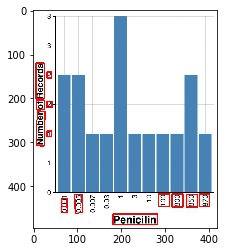

Model input parameters {'image_folder': '__temp_ocr__', 'saved_model': '../models/attn/TPS-ResNet-BiLSTM-Attn-case-sensitive.pth', 'Transformation': 'TPS', 'FeatureExtraction': 'ResNet', 'SequenceModeling': 'BiLSTM', 'Prediction': 'Attn', 'workers': 4, 'batch_size': 192, 'batch_max_length': 25, 'imgH': 32, 'imgW': 100, 'character': '0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 'num_fiducial': 20, 'input_channel': 1, 'output_channel': 512, 'hidden_size': 256, 'rgb': False, 'PAD': False, 'sensitive': True, 'num_class': 96} {'workers': 4, 'batch_size': 192, 'batch_max_length': 25, 'imgH': 32, 'imgW': 100, 'character': '0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 'num_fiducial': 20, 'input_channel': 1, 'output_channel': 512, 'hidden_size': 256, 'rgb': False, 'PAD': False, 'sensitive': True}
loading pretrained model from ../models/attn/TPS-ResNet-BiLSTM-Attn-case-sensitive.pth


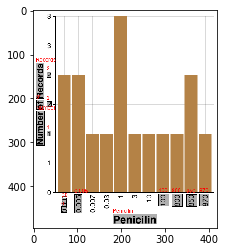

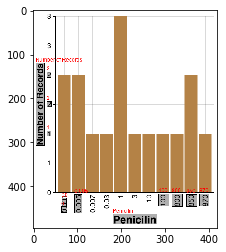

../models/mark_classifier/charts5cats/deploy.prototxt
../models/mark_classifier/charts5cats/snapshots/model_iter_50000.caffemodel
../models/mark_classifier/charts5cats/ilsvrc_2012_mean.npy


{'width': 418,
 'height': 495,
 'title': '',
 'mark': 'bar',
 'encoding': {'x': {'field': '',
   'type': 'quantitative',
   'axis': {'title': 'Penicilin'},
   'scale': {'type': 'sqrt',
    'labels': ['00', '0.005', '100', '800', '850', '870'],
    'values': [0.0, 0.005, 100.0, 800.0, 850.0, 870.0],
    'domain': [0.0, 870.0],
    'range': [71, 389]}},
  'y': {'field': '',
   'type': 'quantitative',
   'axis': {'title': 'Number of Records'},
   'scale': {'type': 'pow',
    'labels': ['1', '2', '2'],
    'values': [1.0, 2.0, 2.0],
    'domain': [1.0, 2.0],
    'range': [281, 147]}}}}

In [13]:
from rev.chart import Chart 
from rev.text.localizer import TextLocalizer 
from rev.text.classifier import TextClassifier 
from rev.spec.generator import SpecGenerator 

import json 
# import torch 
quartz = "../data/quartz/4JevQPPu.png" # from OSF 
quartzII = "../data/quartz/4J0AakdDl.png" # from OSF 
chartp = "../examples/chart.png" 
area = "../examples/image.png" 
vega = "../data/vega/burtin1/mark=bar|x=Penicilin,O|y=count_*,Q.png"
chart = Chart(vega)  

# cuda = torch.cuda.is_available() 

text_classifier = {
    "default": "../models/text_role_classifier/text_type_classifier.pkl" 
} 

localizer = TextLocalizer("craft", 
                          craft_model = "../models/craft/craft_mlt_25k.pth", 
                          craft_params = craft_params, 
                         ocr = "attn", 
                         attn_params = attn_parameters)  

chart.text_boxes = localizer.localize([chart], 
                                      debug = True)[0] 

# print(chart.text_boxes) 

text_clf = TextClassifier(model_checkpoint = text_classifier["default"]) 
text_type_preds = text_clf.classify([chart])

# Set the role for each textbox on the chart
for (text_box, role) in zip(chart.text_boxes, text_type_preds[0]):
    text_box.type = role

# Generate specification and chart mark  
spec_gen = SpecGenerator()
spec = spec_gen.generate([chart]) 

json.loads(spec[0]) 